In [2]:
# cell 00 ... install library dependencies
%pip install -U seaborn

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 292 kB 4.5 MB/s            
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.0
    Uninstalling seaborn-0.10.0:
      Successfully uninstalled seaborn-0.10.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
# cell 00 ... setup Exploratory Data Analysis of Heart Disease Data
import boto3
import sagemaker
from sagemaker import get_execution_role

region = boto3.Session().region_name

session = sagemaker.Session()
s3_bucket = session.default_bucket()
s3_prefix = 'sagemaker/heartdisease/data/'

s3 = boto3.Session().resource('s3')

print(s3_bucket)

sagemaker-us-east-2-645411899653


In [4]:
# cell 01 ... download file from UCI repository

local_data_filename = 'heart_failure_clinical_records_data.csv'
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv -O heart_failure_clinical_records_data.csv

--2021-11-10 22:24:52--  https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12239 (12K) [application/x-httpd-php]
Saving to: ‘heart_failure_clinical_records_data.csv’

heart_failure_clini 100%[===================>]  11.95K  --.-KB/s    in 0s      

2021-11-10 22:24:53 (212 MB/s) - ‘heart_failure_clinical_records_data.csv’ saved [12239/12239]



In [5]:
# cell 02 ... upload file to S3 bucket for later processing

s3.Bucket(s3_bucket).upload_file(local_data_filename, s3_prefix + local_data_filename)

# download file from remote to local
# s3.Bucket(s3_bucket).download_file( s3_remote_path, sm_local_path)

In [30]:
# cell 03 ... read local file to in-memory panda data frame and preview
import pandas as pd

df_heart = pd.read_csv(local_data_filename)
pd.set_option('display.max_columns', 50)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 50)         # Keep the output on one page

# preview data frame
df_heart

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [42]:
# cell 04 ... clean up data set
# drop time column
# rename and move target column to first column for later ML processing via CSV format
# reorder bit flags to front for clarity
df_heart.columns = ['age','anaemia','creatinine_phosphokinase','diabetes', 'ejection_fraction', 'high_blood_pressure','platelets','serum_creatinine','serum_sodium','sex','smoking','time','target_heart_failure']
df_heart

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,target_heart_failure
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [43]:
# cell 05 ... produce summary statistics 
df_heart.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,target_heart_failure
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [9]:
# cell 06 ... produce correlation matrix for all numeric columns
df_heart.corr()

,target_heart_failure,sex,age,smoking,diabetes,anaemia,high_blood_pressure,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium
target_heart_failure,1.000000,-0.004316,0.253729,-0.012623,-0.001943,0.066270,0.079351,0.062728,-0.268603,-0.049139,0.294278,-0.195204
sex,-0.004316,1.000000,0.065430,0.445892,-0.157730,-0.094769,-0.104615,0.079791,-0.148386,-0.125120,0.006970,-0.027566
age,0.253729,0.065430,1.000000,0.018668,-0.101012,0.088006,0.093289,-0.081584,0.060098,-0.052354,0.159187,-0.045966
smoking,-0.012623,0.445892,0.018668,1.000000,-0.147173,-0.107290,-0.055711,0.002421,-0.067315,0.028234,-0.027414,0.004813
diabetes,-0.001943,-0.157730,-0.101012,-0.147173,1.000000,-0.012729,-0.012732,-0.009639,-0.004850,0.092193,-0.046975,-0.089551
anaemia,0.066270,-0.094769,0.088006,-0.107290,-0.012729,1.000000,0.038182,-0.190741,0.031557,-0.043786,0.052174,0.041882
high_blood_pressure,0.079351,-0.104615,0.093289,-0.055711,-0.012732,0.038182,1.000000,-0.070590,0.024445,0.049963,-0.004935,0.037109
creatinine_phosphokinase,0.062728,0.079791,-0.081584,0.002421,-0.009639,-0.190741,-0.070590,1.000000,-0.044080,0.024463,-0.016408,0.059550
ejection_fraction,-0.268603,-0.148386,0.060098,-0.067315,-0.004850,0.031557,0.024445,-0.044080,1.000000,0.072177,-0.011302,0.175902
platelets,-0.049139,-0.125120,-0.052354,0.028234,0.092193,-0.043786,0.049963,0.024463,0.072177,1.000000,-0.041198,0.062125


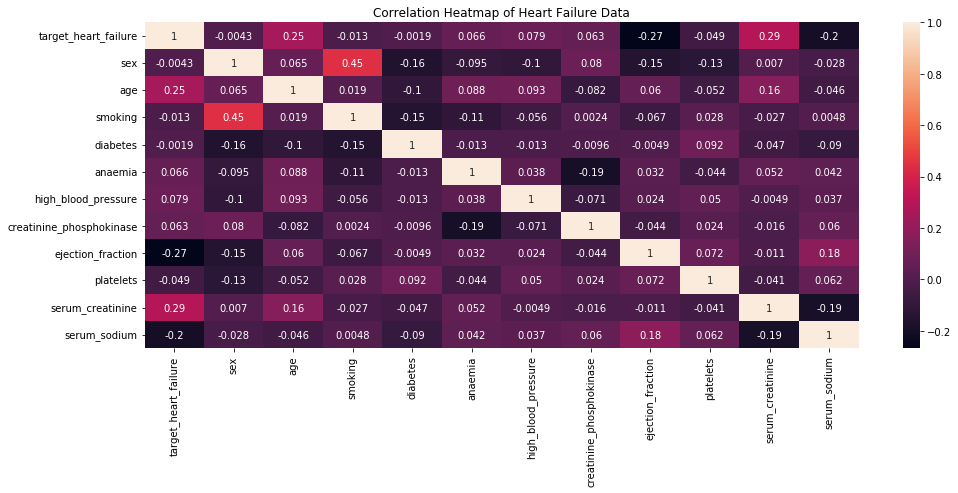

In [10]:
# cell 07 ... produce heatmap
import seaborn
import matplotlib.pyplot as plt

# library pylot settings
plt.figure(figsize=(16,6))

# produce heatmap using correlation matrix
heatmap_heart = seaborn.heatmap(df_heart.corr(), annot=True)
# plot settings
heatmap_heart.set_title('Correlation Heatmap of Heart Failure Data')
heatmap_heart

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb7a802150>,
      dtype=object)

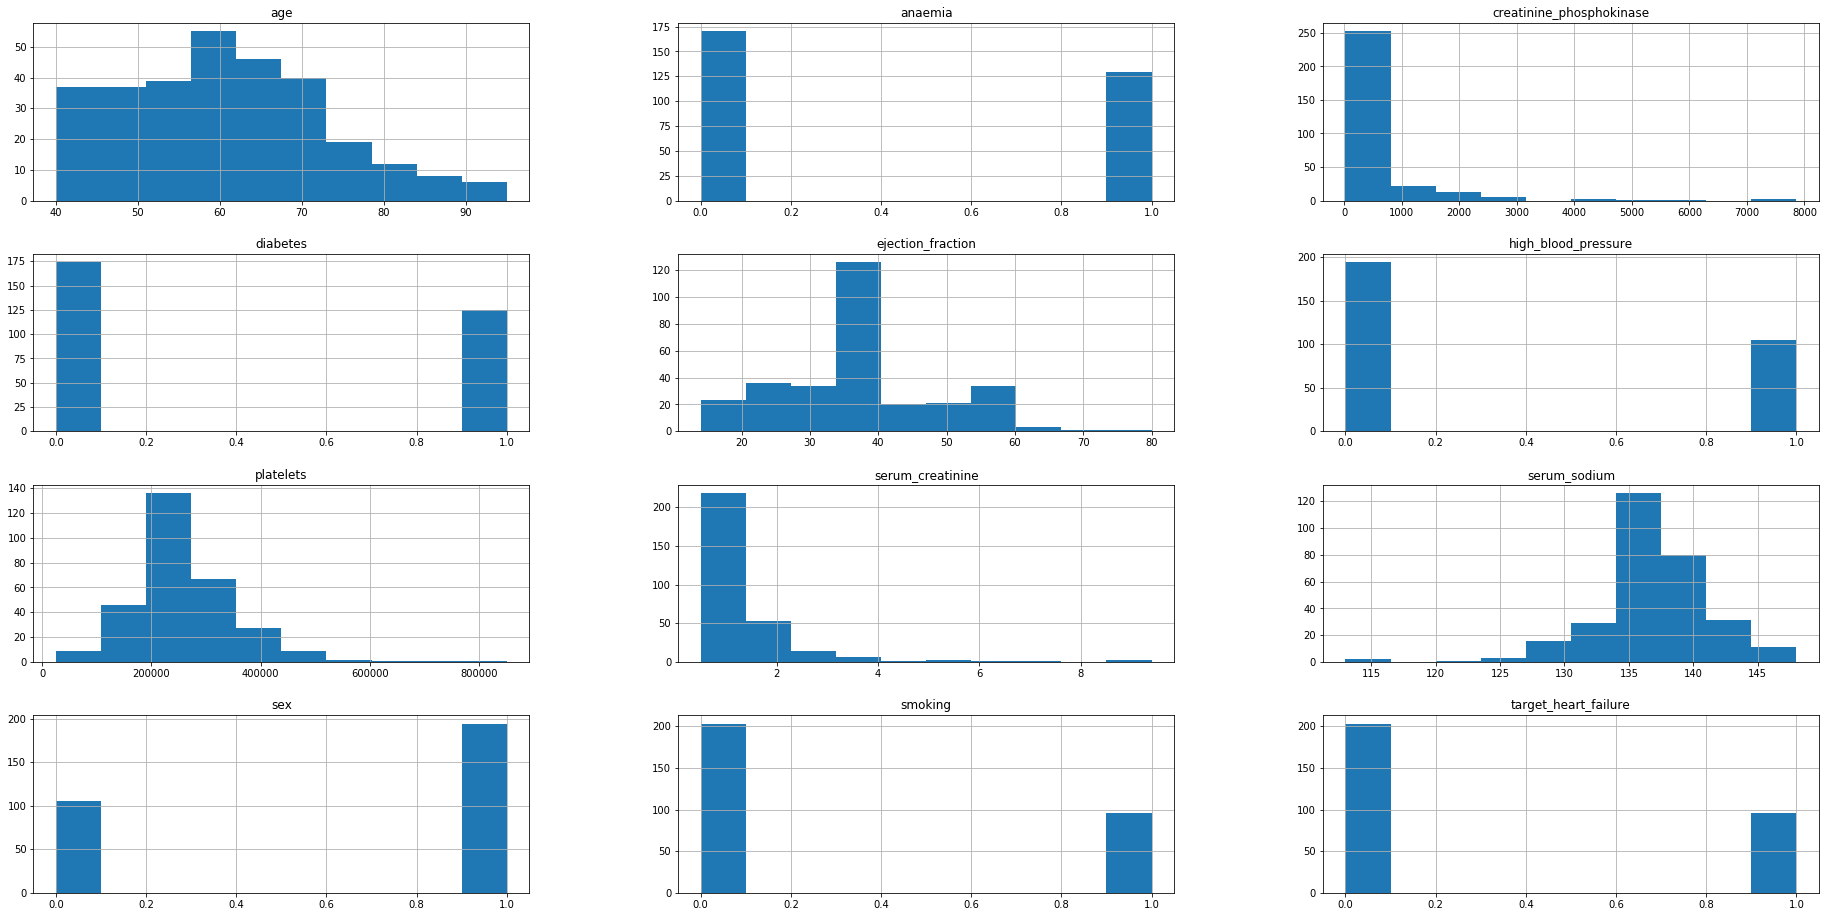

In [12]:
# cell 08 ... investigate distributions of features with highest correlations... age, serum_creatinine, ejection_fraction

df_heart.hist(figsize=(32,16))

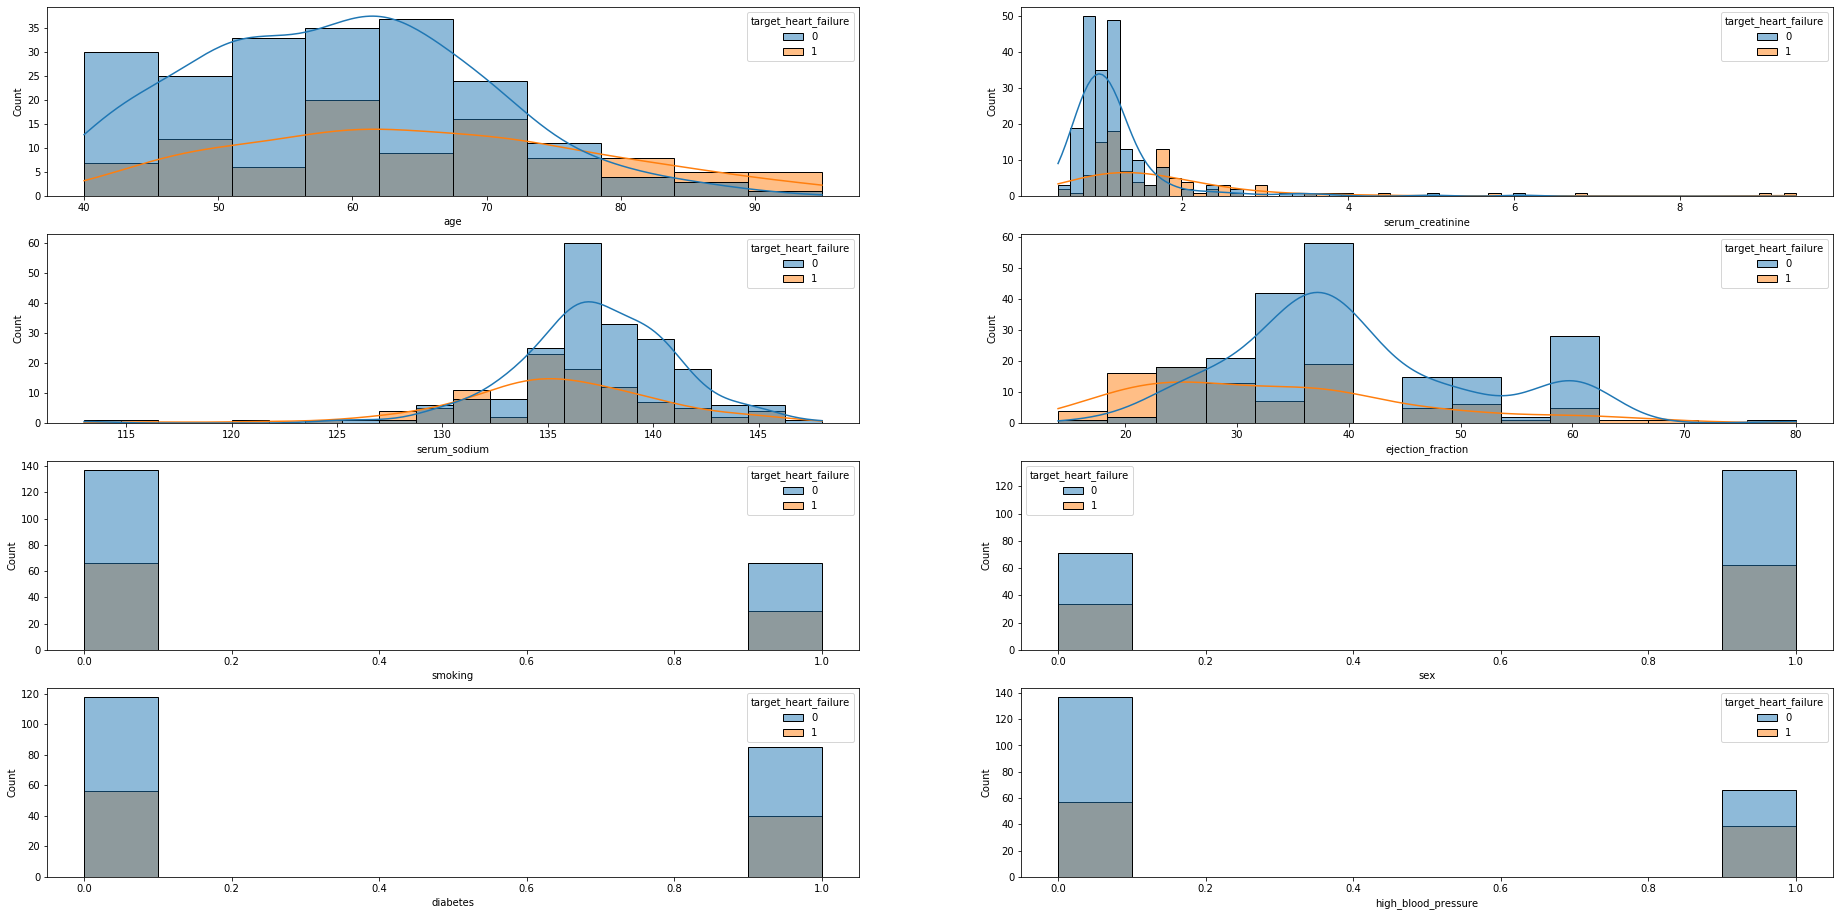

In [13]:
# cell 09a ... investigate ... age, sex, smoking, diabetes, high_blood_pressure, serum_creatinine, serum_sodium

fig, axs = plt.subplots(4, 2, figsize=(32,16))
seaborn.histplot(df_heart, x="age", hue="target_heart_failure",alpha=0.5,kde=True,     ax=axs[0,0])
seaborn.histplot(df_heart, x="serum_creatinine", hue="target_heart_failure",alpha=0.5, kde=True,ax=axs[0,1])
seaborn.histplot(df_heart, x="serum_sodium", hue="target_heart_failure",alpha=0.5, kde=True,ax=axs[1,0])
seaborn.histplot(df_heart, x="ejection_fraction", hue="target_heart_failure",alpha=0.5, kde=True,ax=axs[1,1])
seaborn.histplot(df_heart, x="sex", hue="target_heart_failure",alpha=0.5,     ax=axs[2,1])
seaborn.histplot(df_heart, x="smoking", hue="target_heart_failure",alpha=0.5, ax=axs[2,0])
seaborn.histplot(df_heart, x="diabetes", hue="target_heart_failure",alpha=0.5,ax=axs[3,0])
seaborn.histplot(df_heart, x="high_blood_pressure", hue="target_heart_failure",alpha=0.5, ax=axs[3,1])

plt.show()

In [44]:
# cell 10 ... apply standard scaler on numeric attributes that are not binary to derive columns that have mean 0 and stdev 1

from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

processed_columns = ['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium']
df_heart_preprocessed = df_heart[['target_heart_failure','sex','smoking','diabetes','anaemia','high_blood_pressure']]
df_heart_unprocessed = df_heart[processed_columns]

# preview df_heart_processed_scaled
df_heart_processed_scaled = pd.DataFrame(std_scaler.fit_transform(df_heart_unprocessed))
df_heart_processed_scaled.columns = processed_columns
df_heart_processed_scaled

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium
0,1.192945,0.000166,-1.530560,1.681648e-02,0.490057,-1.504036
1,-0.491279,7.514640,-0.007077,7.535660e-09,-0.284552,-0.141976
2,0.350833,-0.449939,-1.530560,-1.038073e+00,-0.090900,-1.731046
3,-0.912335,-0.486071,-1.530560,-5.464741e-01,0.490057,0.085034
4,0.350833,-0.435486,-1.530560,6.517986e-01,1.264666,-4.682176
...,...,...,...,...,...,...
294,0.098199,-0.537688,-0.007077,-1.109765e+00,-0.284552,1.447094
295,-0.491279,1.278215,-0.007077,6.802472e-02,-0.187726,0.539054
296,-1.333392,1.525979,1.854958,4.902082e+00,-0.575031,0.312044
297,-1.333392,1.890398,-0.007077,-1.263389e+00,0.005926,0.766064


In [45]:
# cell 11 ... preview df_heart_preprocessed
df_heart_preprocessed

,target_heart_failure,sex,smoking,diabetes,anaemia,high_blood_pressure
0,1,1,0,0,0,1
1,1,1,0,0,0,0
2,1,1,1,0,0,0
3,1,1,0,0,1,0
4,1,0,0,1,1,0
...,...,...,...,...,...,...
294,0,1,1,1,0,1
295,0,0,0,0,0,0
296,0,0,0,1,0,0
297,0,1,1,0,0,0


In [51]:
# cell 12 ... concatenate preprocessed and processed columns
df_heart_processed = pd.concat([df_heart_preprocessed, df_heart_processed_scaled], axis=1, ignore_index=False)
df_heart_processed

,target_heart_failure,sex,smoking,diabetes,anaemia,high_blood_pressure,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium
0,1,1,0,0,0,1,1.192945,0.000166,-1.530560,1.681648e-02,0.490057,-1.504036
1,1,1,0,0,0,0,-0.491279,7.514640,-0.007077,7.535660e-09,-0.284552,-0.141976
2,1,1,1,0,0,0,0.350833,-0.449939,-1.530560,-1.038073e+00,-0.090900,-1.731046
3,1,1,0,0,1,0,-0.912335,-0.486071,-1.530560,-5.464741e-01,0.490057,0.085034
4,1,0,0,1,1,0,0.350833,-0.435486,-1.530560,6.517986e-01,1.264666,-4.682176
...,...,...,...,...,...,...,...,...,...,...,...,...
294,0,1,1,1,0,1,0.098199,-0.537688,-0.007077,-1.109765e+00,-0.284552,1.447094
295,0,0,0,0,0,0,-0.491279,1.278215,-0.007077,6.802472e-02,-0.187726,0.539054
296,0,0,0,1,0,0,-1.333392,1.525979,1.854958,4.902082e+00,-0.575031,0.312044
297,0,1,1,0,0,0,-1.333392,1.890398,-0.007077,-1.263389e+00,0.005926,0.766064


In [53]:
# cell 13 ... write processed data to csv file and upload to S3

# local file write
processed_local_data_filename = 'heart_failure_clinical_records_data-02-processed.csv'
df_heart_processed.to_csv(processed_local_data_filename, index=False)

# s3 file write
s3.Bucket(s3_bucket).upload_file(processed_local_data_filename, s3_prefix + processed_local_data_filename)
